Stock Market
=============

Step 1: Define a function to access Yahoo Finance API and extract the information for the stocks and dates requered, then store them as a csv file in the stock directory.

In [1]:
import yahoo_finance
import csv
import os.path

def stock_hist(symbol,start,end):
    columns = ['volume','symbol','adj_close','high','low','date','close','open']
    for j in symbol:
        filepath = "stock/{}.csv".format(j)
        if not os.path.isfile(filepath): 
            
            stock = yahoo_finance.Share(j)
            history = stock.get_historical(start,end)
        
            with open(filepath, "w") as toWrite:
                writer = csv.writer(toWrite,delimiter=",")
                writer.writerow(columns)
                for i in history:
                    temp = []
                    for a in i.keys():
                        temp.append(i[a])
                    writer.writerow(temp)

Step 2: Run the previous function suplying the needed parameters. We will check major Tech companies and the SPY as baseline, use 5 years of data.

In [2]:
symbols = ['SPY','GOOGL','AAPL','TSLA','FB','MSFT','BAC','BRK-B','KO','IR']
start = '2011-09-30'
end = '2016-09-30'

stock_hist(symbol=symbols,start=start,end=end)

Step 3: Read csv files and store as pandas data frames, select subsets of data if needed.

In [3]:
import os
import pandas as pd

def symbol_to_path(symbol,base_dir="stock"):
    return os.path.join(base_dir,"{}.csv".format(str(symbol)))

def get_data(symbols,columns,start,end):
    dates = pd.date_range(start,end)
    df = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol),index_col='date',parse_dates=True,
                              usecols=columns,na_values=['nan'])
        for i in columns:
            df_temp = df_temp.rename(columns={i:symbol+'_'+i})
        df = df.join(df_temp,how='left')
    
    df = df.dropna(subset=['SPY_adj_close'])
    df.columns = symbols
    
    return df
            
columns = ['adj_close','date']    
df = get_data(symbols=symbols,columns=columns,start=start,end=end)
print df.tail()
print "\nThe df is {} rows by {} columns".format(df.shape[0],df.shape[1])

                   SPY       GOOGL        AAPL        TSLA          FB  \
2016-09-26  214.240005  802.650024  112.879997  208.990005  127.309998   
2016-09-27  215.570007  810.729980  113.089996  205.809998  128.690002   
2016-09-28  216.639999  810.059998  113.949997  206.270004  129.229996   
2016-09-29  214.679993  802.640015  112.180000  200.699997  128.089996   
2016-09-30  216.300003  804.059998  113.050003  204.029999  128.270004   

                 MSFT    BAC       BRK-B         KO         IR  
2016-09-26  56.900002  15.09  144.179993  42.049999  65.389999  
2016-09-27  57.950001  15.29  145.339996  42.590000  66.690002  
2016-09-28  58.029999  15.38  145.279999  42.150002  67.489998  
2016-09-29  57.400002  15.16  143.589996  42.029999  67.099998  
2016-09-30  57.599998  15.65  144.470001  42.320000  67.940002  

The df is 1259 rows by 10 columns


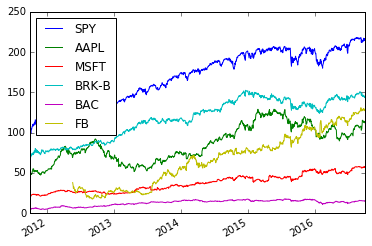

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

df[['SPY','AAPL','MSFT','BRK-B','BAC','FB']].plot()
plt.show()

Stock exchange often has 252 trading days per year, just a reminder.

Step 4: Normalize data, that is make it all start at 1.0 value. So you know, equality and stuff.

In [5]:
ndf = df/df.ix[0,:]
ndf.head()

,SPY,GOOGL,AAPL,TSLA,FB,MSFT,BAC,BRK-B,KO,IR
2011-09-30,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2011-10-03,0.971542,0.962100,0.982377,0.972940,NaN,0.985536,0.903595,0.986205,0.968324,0.942684
2011-10-04,0.992841,0.974487,0.976870,0.970070,NaN,1.018080,0.941176,1.029983,0.965512,0.981844
2011-10-05,1.011224,0.979924,0.991949,1.040180,NaN,1.040177,0.942810,1.030828,0.969953,0.991100
2011-10-06,1.029518,0.999359,0.989641,1.105371,NaN,1.058256,1.026144,1.036458,0.967880,0.999644


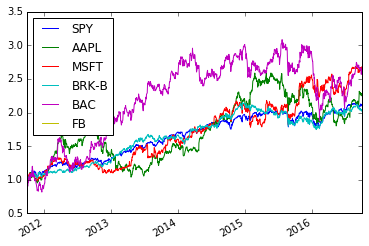

In [6]:
ndf[['SPY','AAPL','MSFT','BRK-B','BAC','FB']].plot()
plt.show()

But what happened to FB? Since it had a NaN value in the position 0, we cannot visualize it normalized (yet at least). We include Google and Tesla which were not included last time.

Lets fill the missing information of FB, first filling backward, then forward.

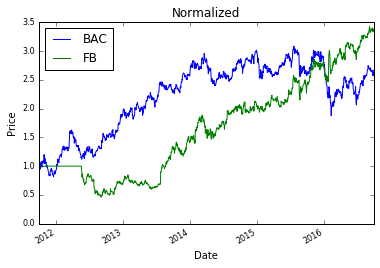

In [7]:
df.fillna(method='ffill',inplace='TRUE')
df.fillna(method='bfill',inplace='TRUE')
ndf = df/df.ix[0,:]

ax = ndf[['BAC','FB']].plot(title='Normalized',fontsize=8)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

Step 5: Rolling statistics and Bollinger Bands

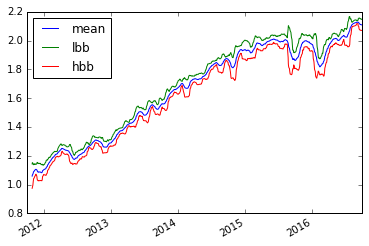

In [8]:
def rolling(df,window=20):
    temp = pd.DataFrame(index=df.index,columns=['mean','std','lbb','hbb'])
    temp['mean'] = df.rolling(window=window,center=False).mean()
    temp['std'] = df.rolling(window=window,center=False).std()
    temp['lbb'] = temp['mean']+2*temp['std']
    temp['hbb'] = temp['mean']-2*temp['std']
    return temp

rolling(ndf).ix[:,(0,2,3)].plot()
plt.show()

Step 7: Check for daily returns and cummulative returns.

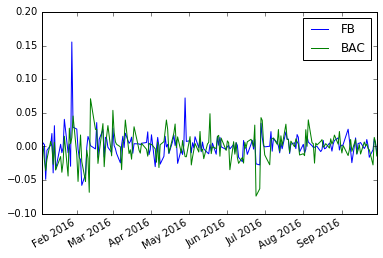

In [9]:
def time_slice(df,start,end):
    start = df.index.searchsorted(start)
    end = df.index.searchsorted(end)
    return df.ix[start:end]

def dR(df):
    tdf = df.copy()
    tdf[1:] = (df[1:]/df[:-1].values)-1
    tdf.ix[0,:] = 0
    return tdf

def dailyReturn(df,n=1):
    ndf = df.copy()
    ndf[n:] = (df[n:]/df[:-n].values)-1
    ndf.ix[range(n),:] = 0
    return ndf


period = time_slice(df,'2016-01-01','2016-09-30')

dR(period)[['FB','BAC']].plot()
plt.show()

dailyReturn = dR(df)

In [10]:
def cum_ret(df,symbol,start,end):
    temp = time_slice(df[symbol],start,end)
    return (temp.ix[-1]/temp.ix[0])-1

print ('FB: {}').format(cum_ret(ndf,'FB','2016-01-01','2016-09-30'))
print ('BAC: {}').format(cum_ret(ndf,'BAC','2016-01-01','2016-09-30'))

FB: 0.25308153734
BAC: -0.0663195214727


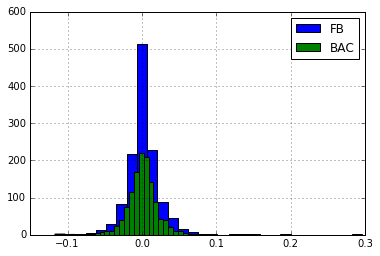

In [11]:
dailyReturn['FB'].hist(bins=30,label="FB")
dailyReturn['BAC'].hist(bins=30,label="BAC")
plt.legend(loc='upper right')
plt.show()

Compare two stocks against each other in a scatter plot.

2.31000266885 -2.16302510214


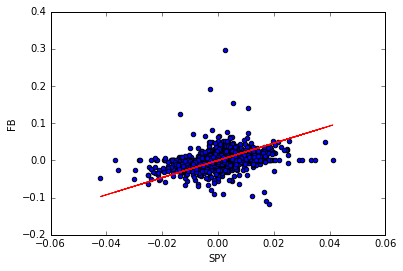

In [12]:
import numpy as np

def fitPol(df,symbol1,symbol2='SPY',n=1):
    return np.polyfit(df[symbol1],df[symbol2],n)

beta, alpha = fitPol(ndf,'SPY','FB') #mx + b
print beta, alpha

dailyReturn.plot(kind='scatter',x='SPY',y='FB')
plt.plot(dailyReturn['SPY'],beta*dailyReturn['SPY'],'-',color='r')
plt.show()

Define a function to check the main global statistics for each stock.

In [13]:
def stats(df,drf=0,samples=252):
    temp = pd.DataFrame(index=df.columns.values,columns=['mean','std','kurtosis','sharpe'])
    temp['mean'] = df.mean()
    temp['std'] = df.std()
    temp['kurtosis'] = df.kurtosis()
    temp['sharpe'] = (samples**0.5)*((df.mean()-drf)/df.std())
    return temp

stats(time_slice(dailyReturn,'2016-01-01','2016-09-30'))

,mean,std,kurtosis,sharpe
SPY,0.000397,0.008991,1.757237,0.700836
GOOGL,0.000252,0.013155,2.548536,0.304577
AAPL,0.000557,0.016059,3.738635,0.550690
TSLA,-0.000617,0.025743,2.419050,-0.380776
FB,0.001249,0.019006,23.593237,1.043282
MSFT,0.000404,0.015154,3.941585,0.422962
BAC,-0.000271,0.021066,1.710353,-0.204278
BRK-B,0.000493,0.009716,1.865525,0.805818
KO,0.000051,0.009131,4.877937,0.088020
IR,0.001244,0.016268,2.508201,1.214039


# Portfolios

Where we analyse more than one stock at a time.

Step 9: Allocate a portfolio (choose which and how much).
- Take stock price df
- Normalize it
- Select allocations (sum = 1.0)
- Get a huge amount of money to invest, multiply it by allocation
- We are interested in Deltas!

In [14]:
amount = 1000000
allocation = pd.DataFrame(columns=ndf.columns.values,index=['allocation'])
allocation.ix[0,:] = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
port_val = np.sum(allocation,axis=1)

def portVal(df,allocation):
    return np.sum(np.multiply(df/df.ix[0,:],allocation.values),axis=1)

pval = portVal(time_slice(df,'2016-01-01','2016-09-30'),allocation)
print "Current portfolio value: {}".format(round(port_val.values[0],3))
print 'Future portfolio value: {}'.format(round(pval.ix[-1],3))

Current portfolio value: 1.0
Future portfolio value: 1.073


Step 10: Compute Sharpe ratio

Risk free rate:
- LIBOR
- 3mo T-bill
- 0%

K's
- daily = sqrt(252)
- weekly = sqrt(52)
- monthly = sqrt(12)

In [15]:
def daily_rf(interest,time):
    return ((1+interest)**(1/time))-1

def sharpe(daily_rets,daily_rf,std_ret):
    return (daily_rets-daily_rf)/(std_ret)

def k(samples):
    return (samples)**0.5

What is the Sharpe ratio?
- 60 days of data
- Mean Daily Return = 10 bps = 0.001
- Daily Risk Free = 2 bps = 0.0002
- Std Daily Return = 10 bps = 0.001

In [16]:
mdr = 0.001           # Already provided as mean and std
drf = 0.0002
sdr = 0.001

'Sharpe ratio: {}'.format(round(k(252)*sharpe(mdr,drf,sdr),1))

'Sharpe ratio: 12.7'

Key values in evaluating a portfolio:
- Cumulative return
- Average daily return
- Risk
- Sharpe ratio

In [17]:
portfolio = dailyReturn.sum(axis=1)
mdr = portfolio.mean()
sdr = portfolio.std()
drf = 0.002
samples = 252 # Daily traiding days

'Sharpe ratio: {}'.format(round(k(samples)*sharpe(mdr,drf,sdr),2))

'Sharpe ratio: 1.17'

[Usually, any Sharpe ratio greater than 1 is considered acceptable to good by investors. A ratio higher than 2 is rated as very good, and a ratio of 3 or higher is considered excellent.](http://www.investopedia.com/ask/answers/010815/what-good-sharpe-ratio.asp#ixzz4LI74kuJG)

What would our portfolio look like from begining to end, the cumulative sum of daily returns?

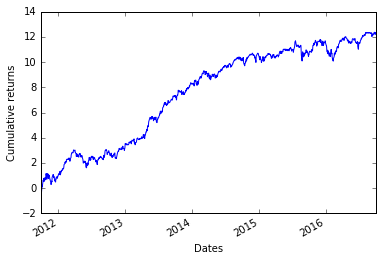

In [18]:
ax = portfolio.cumsum().plot()
ax.set_xlabel('Dates')
ax.set_ylabel('Cumulative returns')
plt.show()

Step 11: Optimize the allocation of fonds for the stocks in the portfolio.
- Maximize (Minimize) a function (Cumulative return, daily return, Risk, Sharpe Ratio)
- Choose which stock, how much to allocate to each stock.

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.48911925553
            Iterations: 5
            Function evaluations: 60
            Gradient evaluations: 5
SPY 0.0
GOOGL 0.0
AAPL 0.0
TSLA 0.0
FB 0.43
MSFT 0.0
BAC 0.0
BRK-B 0.0
KO 0.0
IR 0.57
Sharpe Ratio: 1.49


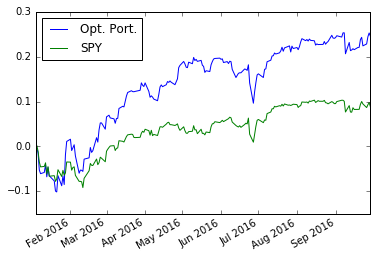

In [19]:
import scipy.optimize as spo
portfolio = dR(time_slice(df,'2016-01-01','2016-09-30'))

def sharpe(allocation,portfolio,drf=0,samples=252):
    portfolio = (portfolio*allocation).sum(axis=1)
    return -1.*np.sqrt(samples)*(portfolio.mean()-drf)/portfolio.std()

def risk(allocation,portfolio):
    portfolio = (portfolio*allocation).sum(axis=1)
    return portfolio.std()

def profit(allocation,portfolio):
    portfolio = (portfolio*allocation).sum(axis=1)
    return -1.*portfolio.sum()

def portOpt(f,portfolio):
    cons = ({'type':'eq','fun':lambda x: 1-sum(x)}) # sum(abs(x))
    allocation = list()
    bounds = list()

    n = portfolio.shape[1]
    for i in range(n):
        allocation.append(1./n)
        bounds.append((0,1)) # (-1,1)


    return spo.minimize(f,allocation,args=(portfolio,),method='SLSQP',
        options={'disp':True},bounds=bounds,constraints=cons)

result = portOpt(sharpe,portfolio)

for i, j in zip(portfolio.columns.values,np.round(result.x,2)):
    print i,j

print "Sharpe Ratio: {}".format(np.round(-sharpe(result.x,portfolio),2))

ax = (portfolio*result.x).sum(axis=1).cumsum().plot(label='Opt. Port.')
portfolio['SPY'].cumsum().plot(label="SPY",ax=ax)
ax.legend(loc='upper left')
plt.show()

Step 12: Types of funds.
- ETF (Exchange Traded Fund)
- Mutual Fund
- Hedge Fund

Step 13: True value of the company.
- Intrinsic value (Value from earnings over the time)
- Book value Assets (not int. assets) - liability
- Market cap #shares * price

In [20]:
# The value of a future dollar
def pv(fv,ir,i):
    return fv/(1+ir)**i

ir = 0.05
i = 1
fv = 1

print pv(fv,ir,i)

0.952380952381


[Yahoo Finance](https://pypi.python.org/pypi/yahoo-finance/1.1.4)

Step 14 Capital Asset Pricing Model:

In [21]:
# CAPM equation
def rit(rmt,beta,alpha):
    return beta*rmt+alpha

# Return for an individual day is b times return of the market + alpha of the stock on that day
# calculate beta and alpha for all stocks (vs spy) according to capm expected alpha = 0
# How well is the market followed by the stock in the portfolio?
# Active investor, can predict alpha. Passive investor, alpha is random mean 0.
# sp500 how the stock relates to the market

# arbitrage pricing theory
# high Beta on up markets
# low beta in down markets

def portLin(df):
    symbols = df.columns.values
    temp = (pd.DataFrame(index=symbols,columns=['beta','alpha']))
    
    for i in range(symbols.shape[0]):
        temp.ix[i,0], temp.ix[i,1] = fitPol(df,symbols[i])
    
    return temp

beta_alpha = portLin(dailyReturn)
beta_alpha

,beta,alpha
SPY,1,0
GOOGL,0.34169,0.000289281
AAPL,0.264698,0.000426183
TSLA,0.0989634,0.000417229
FB,0.105274,0.000504569
MSFT,0.370047,0.000307308
BAC,0.307497,0.000333703
BRK-B,0.72838,0.000188492
KO,0.550675,0.00044823
IR,0.39686,0.000209772


In [22]:
def riskPro(allocation,betas,alphas):
    return np.sum(np.multiply(betas,allocation)),np.sum(np.multiply(alphas,allocation))

betas = [1,2]
alphas = [.01,-.01]
market = -.1
allocation = [50,-50]

print riskPro(allocation,betas,alphas)

allocation = [50*2./3,-50*1./3]

print riskPro(allocation,betas,alphas)
# Beta for portfolio = 0
# Maximize alpha
riskPro(result.x,beta_alpha['beta'],beta_alpha['alpha'])

(-50, 1.0)
(0.0, 0.5)


(0.2702816936277283, 0.00033774471447225058)

- Technical analysis only prices and volume, find heuristics and trends on them
- Individual indicators are weak, combinations are stronger
- Look for contrasts (stock vs market)
- use short periods of time, less complexity
- trading strategy opposed to investment strategt
- Indicators
- momentum, simple moving average, bollinger bands(r) (derivatives?)

Step ##: Risk management

- performance = skill x breath^0.5
- expected value = (chance to win - chance to lose) * bet
- probability to lose all = (chance to lose)^# of bets
- reward/risk = expected value / std()
- expected return multi = expected return single x # of bets ^ 0.5
- Information Ratio = alpha = mean(alphas)/std(alphas)  (historic daily alphas)

The fundamental law:

- information ratio = Information coeficient * breadth ^0.5
- Information coeficient = correlation of forecasts to returns

# Machine Learning for Trading

x's = price momentum, bollinger value, current price

y's = future return, future price

Parameters to use as shown in the lecture.

![parameters](parameters.png)